### MACHINE UNLEARNING

## Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline
import utils
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from itertools import cycle
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *
import wandb
from thirdparty.repdistiller.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from thirdparty.repdistiller.distiller_zoo import DistillKL, HintLoss, Attention, Similarity, Correlation, VIDLoss, RKDLoss
from thirdparty.repdistiller.distiller_zoo import PKT, ABLoss, FactorTransfer, KDSVD, FSP, NSTLoss
from thirdparty.repdistiller.helper.loops import train_distill, train_distill_hide, train_distill_linear, train_vanilla, train_negrad, train_bcu, train_bcu_distill, validate
from thirdparty.repdistiller.helper.pretrain import init
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\shr91\AppData\Local\Temp\ipykernel_18472\611943025.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Train Original Model

This cell will run main.py which generate a model and leave many checkpoints for later references. We
prepare standard_model_for_pilot for the sake of pilot.

dataset: mnist

possible datasets, (specifically refer to the dataset_multiclass.py)
cifar10,small_cifar5,small_cifar6,small_cifar10,small_binary_cifar10,
cifar100,mnist,small_mnist,lacuna100,lacuna10,small_lacuna5,small_lacuna6,small_lacuna10
small_binary_lacuna10,tinyimagenet_pretrain,tinyimagenet_finetune,tinyimagenet_finetune5,mix10,mix100

model: mlp

possible models (refer to models.py)
ntk_wide_resnet, is_wide_resnet, wide_resnet, resnet_small, resnet, allcnn_no_bn, ntk_allcnn
smallallcnn, allcnn, ntk_mlp, ntk_linear, mlp

dataroot: data/MNIST
resume from standard_model_for_pilot.pt in checkpoints folder

In [2]:
%run main.py --dataset mnist --model mlp --dataroot=data/MNIST/ --filters 1.0 --lr 0.001 \
--resume checkpoints/standard_model_for_pilot.pt --disable-bn \
--weight-decay 0.1 --batch-size 128 --epochs 31 --seed 3

Checkpoint name: mnist_mlp_1_0_forget_None_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3
[Logging in mnist_mlp_1_0_forget_None_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_training]
confuse mode: False
split mode: None
Number of Classes: 10
State OrderedDict([('layers.0.weight', tensor([[-0.0832, -0.0317,  0.0080,  ...,  0.0650, -0.0346, -0.0338],
        [-0.0027, -0.0888, -0.0519,  ..., -0.0379,  0.0615,  0.0149],
        [-0.1416, -0.0336,  0.0156,  ...,  0.0427,  0.0694,  0.0308],
        ...,
        [-0.0182, -0.0285,  0.0117,  ...,  0.0094, -0.0225, -0.0526],
        [-0.0159,  0.0288, -0.0066,  ...,  0.0381,  0.0633,  0.0451],
        [ 0.0131, -0.0608,  0.0516,  ..., -0.0093,  0.0415, -0.0130]])), ('layers.0.bias', tensor([ 0.2570,  0.5360, -0.9828, -0.2736, -0.2282,  0.3082,  0.4359, -0.1057,
        -0.0857,  0.2738,  0.0112, -0.4476,  0.2455,  0.2458, -0.0411, -0.3458,
        -0.4463,  0.1637, -0.5212,  0.0843,  0.1513, -0.1780, -0.6362,  0.2063,
         0.4134,  0.2404, -0.3497, -0.2096, -

# Note
After running this cell, the code will generate a trace of checkpoints under the "checkpoints" folder.
They are useful for later cell codes. But you could remove them after completing the experiment.

Also, the code would also download a MNIST dataset in the data folder. You could remove it after the
experiment.

The code also generate a log file under "logs" folder if one wants to analyze using matlab. You could
remove it after the experiment.

## Train Retain Model

This code is used to train the retain model. The specific change compared to the upper cell (to train
the original model) is the forget class command. This command refers datasets.get_loaders() in main.py
and in dataset_multiclass.py, four functions are used to separate the retain class and the forget
class. They are replace_indexes(), replace_class(), confuse_class(), get_loaders().


In [3]:
%run main.py --dataset mnist --model mlp --dataroot=data/MNIST/ --filters 1.0 --lr 0.001 \
--resume checkpoints/standard_model_for_pilot.pt --disable-bn \
--weight-decay 0.1 --batch-size 128 --epochs 31 \
--forget-class 0,1,2,3,4,5 --num-to-forget 300 --seed 3

Checkpoint name: mnist_mlp_1_0_forget_[0, 1, 2, 3, 4, 5]_num_300_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3
[Logging in mnist_mlp_1_0_forget_[0, 1, 2, 3, 4, 5]_num_300_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_training]
confuse mode: False
split mode: None
Replacing indexes [ 8526 16694 15152 29352   141 36509 37843 16926 35321 26042 21345  5714
 47547 14437 39793 44980 45137  3897 35780 29999 33655 37420 40980 28992
   105 40544 41016 46885 46091 40786  5543  7014 20505 25936 16792  2457
  1600 13007  7760 15774 46362 33702 32877  2543 33599 32886 35244 29239
  8640 23665 45315  3038 22738  3554  4458 36789 11462  2191 23706 10872
  9290 32216 25081 12968 28129 20523  5261 16762 26382 19263 12728 37875
 36911  7326 21202 31998 26810 28700 36488 42838  3180 24261 25761 13600
 18425 29148 39305  4254  2025  4307 45980 28150 36331  8747 35060 28517
  8694 12015 38188 36605 26116 12256 18607 11847  1442 19196 18989 33194
 26487  5803   828 40152 11342 43196 20715 41802 14043  8865 20144 41373
 47285  

## Analysis

This function will count the parameters in the model.

In [4]:
def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')

Importantly, the model object is an empty object in this. It is not initialized with our previous trained models.
Here, we measure the parameters in the empty model object. (Original interpretation)

Note: deepcopy will give you the entire object, while other methods only gives you the reference pointer (for references,
see Java, C basics).

Or, the model object is from the main.py code.

I have not figured out this yet. I think the model object is from the main.py code and the later code use
deep copy to make sure everything is aligned.


In [5]:
parameter_count(copy.deepcopy(model))

Total Number of Parameters: 33130


## Initialize original model and retain model

Here, we will use the checkpoints references to get the models that we have trained in the previous cells. The models
that is initialized is in the cache of this jupyter notebook workflow.

Initialize three empty model objects

In [6]:
model_original = copy.deepcopy(model)
model_retain = copy.deepcopy(model)
model_pretrain = copy.deepcopy(model)

We use checkpoint name to refer to the objects. Thus, here we initialize all the name parameters.

In [7]:
arch = args.model
filters=args.filters
arch_filters = arch +'_'+ str(filters).replace('.','_')
augment = False
dataset = args.dataset
class_to_forget = args.forget_class
init_checkpoint = f"checkpoints/{args.name}_init.pt"
num_classes=args.num_classes
num_to_forget = args.num_to_forget
num_total = len(train_loader.dataset)
num_to_retain = num_total - 300#num_to_forget
seed = args.seed
unfreeze_start = None
learningrate=f"lr_{str(args.lr).replace('.','_')}"
batch_size=f"_bs_{str(args.batch_size)}"
lossfn=f"_ls_{args.lossfn}"
wd=f"_wd_{str(args.weight_decay).replace('.','_')}"
seed_name=f"_seed_{args.seed}_"
num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
augment_tag = '' if not augment else f'augment_'
training_epochs=30
log_dict={}
log_dict['epoch']=training_epochs

Here, we get the name of the model we want to get.

In [8]:
m_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
m0_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

Make sure the names are correct.

In [9]:
print(m_name)

checkpoints/mnist_mlp_1_0_forget_None_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_30.pt


In [10]:
print(m0_name)

checkpoints/mnist_mlp_1_0_forget_[0, 1, 2, 3, 4, 5]_num_300_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_30.pt


In [11]:
print(init_checkpoint)

checkpoints/mnist_mlp_1_0_forget_[0, 1, 2, 3, 4, 5]_num_300_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_init.pt


We get the original model, the retain, and the pretrained model that we used to train the original model and the
retain model.

In [12]:
model_original.load_state_dict(torch.load(m_name))
model_retain.load_state_dict(torch.load(m0_name))
model_pretrain.load_state_dict(torch.load(init_checkpoint))

<All keys matched successfully>

## Analysis

We use parameters to see if we actually get the models from the checkpoints.

In [13]:
parameter_count(copy.deepcopy(model_original))
parameter_count(copy.deepcopy(model_retain))
parameter_count(copy.deepcopy(model_pretrain))

Total Number of Parameters: 33130
Total Number of Parameters: 33130
Total Number of Parameters: 33130


We analyze the parameters in the model

In [14]:
for p in model_original.parameters():
    p.data0 = p.data.clone()
print("Model_Original:", p)

for p in model_pretrain.parameters():
    p.data0 = p.data.clone()
print("Model_Pretrain", p)

for p in model_pretrain.parameters():
    p.data0 = p.data.clone()
print("Model_Retain", p)

Model_Original: Parameter containing:
tensor([ 0.2353,  0.7190,  0.5154,  0.0759,  0.2476, -0.0129,  0.2155,  0.3334,
        -0.1101, -0.5481], requires_grad=True)
Model_Pretrain Parameter containing:
tensor([ 0.2496,  0.6326,  0.5569,  0.1073,  0.2888, -0.0639,  0.1895,  0.2966,
        -0.0117, -0.5746], requires_grad=True)
Model_Retain Parameter containing:
tensor([ 0.2496,  0.6326,  0.5569,  0.1073,  0.2888, -0.0639,  0.1895,  0.2966,
        -0.0117, -0.5746], requires_grad=True)


We use distances to further analyze the three models. First, we define the distance function.

In [15]:
# this method take the model object, then, iterate each parameter in the model.parameters() [this will
# return the parameters set in the model object]. for each parameter object, we name another parameter
# that is the same as the parameter, in named_parameters, later, in the distance function, we use
# this copy of parameters, to measure the distance.
def named_parameters_creat(model_):
    for p in model_.parameters():
        p.data0 = p.data.clone()

def distance(model,model0):
    distance=0
    normalization=0

    # Create named parameters in the model object as a copy of the original parameters
    named_parameters_creat(model)
    named_parameters_creat(model0)

    # Calculate distance iterating through the named parameters
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        space='  ' if 'bias' in k else ''
        current_dist=(p.data0-p0.data0).pow(2).sum().item()
        current_norm=p.data0.pow(2).sum().item()
        distance+=current_dist
        normalization+=current_norm

    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

We compare original model and the retain model.

In [16]:
distance(model_original,model_retain)

Distance: 0.017273186520086487
Normalized Distance: 0.0017248963048984115


0.0017248963048984115

We compare the retain model and the pre-trained model

In [17]:
distance(model_pretrain,model_retain)

Distance: 2.838099897601149
Normalized Distance: 0.3046515850998754


0.3046515850998754

We compare the pretrain model and the original model

In [18]:
distance(model_pretrain, model_original)

Distance: 2.8384955687527356
Normalized Distance: 0.3046940578273545


0.3046940578273545

## Prepare Dataset for Unlearning

explicit documentation has been add to datasets_multiclass.py

initialize retain and forget dataset batch size. And get forget dataset.

Forget class has been originated when we train the model in main.py and it is given in jupyter notebook
in our previous initialization section. To change the forget class, we need to re-run the main.py where
we get the retain model.

It is in the name.

In [19]:
args.retain_bs = 32
args.forget_bs = 64
train_loader_full, valid_loader_full, test_loader_full   = datasets.get_loaders(dataset, batch_size=args.batch_size, seed=seed, root=args.dataroot, augment=False, shuffle=True)
marked_loader, _, _ = datasets.get_loaders(dataset, class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, root=args.dataroot, augment=False, shuffle=True)

confuse mode: False
split mode: train
confuse mode: False
split mode: train
Replacing indexes [ 8526 16694 15152 29352   141 36509 37843 16926 35321 26042 21345  5714
 47547 14437 39793 44980 45137  3897 35780 29999 33655 37420 40980 28992
   105 40544 41016 46885 46091 40786  5543  7014 20505 25936 16792  2457
  1600 13007  7760 15774 46362 33702 32877  2543 33599 32886 35244 29239
  8640 23665 45315  3038 22738  3554  4458 36789 11462  2191 23706 10872
  9290 32216 25081 12968 28129 20523  5261 16762 26382 19263 12728 37875
 36911  7326 21202 31998 26810 28700 36488 42838  3180 24261 25761 13600
 18425 29148 39305  4254  2025  4307 45980 28150 36331  8747 35060 28517
  8694 12015 38188 36605 26116 12256 18607 11847  1442 19196 18989 33194
 26487  5803   828 40152 11342 43196 20715 41802 14043  8865 20144 41373
 47285  8202 21858  1815 22335  2739 16404  6882  9838 14297  4773 29745
  8784 20420  9033 18865 39460 23585 14421 25902 31362 17568 47282 10213
 10851 27398  9097 13317  3946

In this case, we define a function that puts the dataset into the data loader.

In [20]:
def replace_loader_dataset(data_loader, dataset, batch_size=args.batch_size, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)

Get forget dataset

In [21]:
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, batch_size=args.forget_bs, seed=seed, shuffle=True)

Get retain dataset

In [22]:
retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, batch_size=args.retain_bs, seed=seed, shuffle=True)

Make sure everything is working

In [23]:
assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))
print (len(forget_loader.dataset))
print (len(retain_loader.dataset))
print (len(test_loader_full.dataset))
print (len(train_loader_full.dataset))
from collections import Counter
print(dict(Counter(train_loader_full.dataset.targets)))

300
47704
10000
48004
{5: 4337, 4: 4674, 9: 4760, 2: 4767, 1: 5394, 3: 4905, 6: 4735, 7: 5012, 8: 4681, 0: 4739}


## Fine-tuning with Retain Dataset

This function calculates the L2 regularization penalty term for the model's weights by comparing them to the initial
 (untrained) model's weights

In [24]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

Define training function for fine-tune.

In [25]:
from utils import *

def run_finetune_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, epoch=int):

    # you set the model's internal state to indicate that it's being used for inference or evaluation, not for training.
    # It ensures that certain layers and behaviors in the model are adjusted for this purpose
    model.eval()

    # Computes and stores the average and current value, defined in utils.py
    metrics = AverageMeter()

    with torch.set_grad_enabled(True):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            model.zero_grad()
            loss.backward()
            optimizer.step()
    return metrics.avg

In [26]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_finetune_train_epoch(model, model_init, data_loader, loss_fn, optimizer, epoch=epoch)

In [27]:
model_ft = copy.deepcopy(model)
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.batch_size, shuffle=True)
finetune(model_ft, retain_loader, epochs=10, quiet=True, lr=0.01)

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

## Negative Gradients

In [28]:
def negative_grad(model: nn.Module, data_loader: torch.utils.data.DataLoader, forget_loader: torch.utils.data.DataLoader, alpha: float, lr=0.01, epochs=10):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_neggrad_epoch(model, model_init, data_loader, forget_loader, alpha, loss_fn, optimizer, epoch=epoch)

In [29]:
def run_neggrad_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader,
                    forget_loader: torch.utils.data.DataLoader,
                    alpha: float,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, epoch: int):
    model.eval()
    metrics = AverageMeter()
    with torch.set_grad_enabled(True):
        for idx, (batch_retain,batch_forget) in enumerate(tqdm(zip(data_loader,cycle(forget_loader)), leave=False)):
            batch_retain = [tensor.to(next(model.parameters()).device) for tensor in batch_retain]
            batch_forget = [tensor.to(next(model.parameters()).device) for tensor in batch_forget]
            input_r, target_r = batch_retain
            input_f, target_f = batch_forget
            output_r = model(input_r)
            output_f = model(input_f)
            # Negative Gradient Loss Function
            loss = alpha*(loss_fn(output_r, target_r) + l2_penalty(model,model_init,args.weight_decay)) - (1-alpha)*loss_fn(output_f, target_f)
            metrics.update(n=input_r.size(0), loss=loss_fn(output_r,target_r).item(), error=get_error(output_r, target_r))
            model.zero_grad()
            loss.backward()
            optimizer.step()
    return metrics.avg

In [30]:
args.ng_alpha = 0.95
args.ng_epochs = 10
args.ng_lr = 0.01
model_negative_gradient = copy.deepcopy(model)
negative_grad(model_negative_gradient, retain_loader, forget_loader, alpha=args.ng_alpha, epochs=args.ng_epochs, lr=args.ng_lr)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Fisher Forgetting

In [31]:
model_fisher_on_original = copy.deepcopy(model_original)
model_fisher_on_pretrained = copy.deepcopy(model_pretrain)
for p in itertools.chain(model_fisher_on_original.parameters(), model_fisher_on_pretrained.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [32]:
def hessian(data_set, model):
    model.eval()
    train_loader = torch.utils.data.DataLoader(data_set, batch_size=1, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()
    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0
    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(args.device), orig_target.to(args.device)
        output = model(data)
        prob = F.softmax(output, dim=-1).data
        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2)
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [33]:
def get_mean_var(p, is_base_dist=False, alpha=3e-6):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3)
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    if not is_base_dist:
        mu = copy.deepcopy(p.data0.clone())
    else:
        mu = copy.deepcopy(p.data0.clone())
    if p.size(0) == num_classes and num_to_forget is None:
        mu[class_to_forget] = 0
        var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10
    return mu, var
def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

In [34]:
hessian(retain_loader.dataset, model_fisher_on_original)
hessian(retain_loader.dataset, model_fisher_on_pretrained)

  0%|          | 0/47704 [00:00<?, ?it/s]

  0%|          | 0/47704 [00:00<?, ?it/s]

In [35]:
# Computes the amount of information not forgotten at all layers using the given alpha

alpha = 1e-7
total_kl = 0
torch.manual_seed(seed)
for (k, p), (k0, p0) in zip(model_fisher_on_original.named_parameters(), model_fisher_on_pretrained.named_parameters()):
    mu0, var0 = get_mean_var(p, False, alpha=alpha)
    mu1, var1 = get_mean_var(p0, True, alpha=alpha)
    kl = kl_divergence_fisher(mu0, var0, mu1, var1).item()
    total_kl += kl
    print(k, f'{kl:.1f}')
print("Total:", total_kl)
log_dict['fisher_info']=total_kl

layers.0.weight 84078.1
layers.0.bias 2873.3
layers.2.weight 47328.5
layers.2.bias 1491.0
Total: 135770.9493408203


In [36]:
fisher_dir = []
alpha = 1e-6
torch.manual_seed(seed)
for i, p in enumerate(model_fisher_on_original.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()
    fisher_dir.append(var.sqrt().view(-1).cpu().detach().numpy())
for i, p in enumerate(model_fisher_on_pretrained.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

In [37]:
print(fisher_dir)

[array([0.02581239, 0.02581239, 0.02581239, ..., 0.02663051, 0.02663051,
       0.02663051], dtype=float32), array([0.0112033 , 0.01925907, 0.1       , 0.01317145, 0.01422679,
       0.01722576, 0.01903651, 0.01380545, 0.02635191, 0.01516563,
       0.08655215, 0.1       , 0.02218408, 0.01602794, 0.01262238,
       0.01443665, 0.01447893, 0.01836849, 0.1       , 0.01328964,
       0.01359341, 0.1       , 0.05436911, 0.01596258, 0.01382499,
       0.01617315, 0.01868596, 0.01819735, 0.03455006, 0.0157376 ,
       0.01481927, 0.01508808], dtype=float32), array([0.02051884, 0.02051884, 0.02051884, 0.02051884, 0.02051884,
       0.02051884, 0.02051884, 0.02051884, 0.02051884, 0.02051884,
       0.02051884, 0.02051884, 0.02051884, 0.02051884, 0.02051884,
       0.02051884, 0.02051884, 0.02051884, 0.02051884, 0.02051884,
       0.02051884, 0.02051884, 0.02051884, 0.02051884, 0.02051884,
       0.02051884, 0.02051884, 0.02051884, 0.02051884, 0.02051884,
       0.02051884, 0.02051884, 0.024226

In [38]:
model_fisher = copy.deepcopy(model_fisher_on_original)

# Test

In [39]:
# 定义测试函数
def evaluate(model: nn.Module, data_loader: torch.utils.data.DataLoader) -> float:
    """
    返回模型在给定的数据加载器上的错误率
    """
    model.eval()
    total_samples = 0
    total_mistakes = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(next(model.parameters()).device), target.to(next(model.parameters()).device)
            output = model(data)
            prediction = torch.argmax(output, dim=1)
            mistakes = torch.sum(prediction != target).item()
            total_mistakes += mistakes
            total_samples += data.size(0)

    error_rate = total_mistakes / total_samples
    return error_rate

# 计算error
models = {
    "Fine-tuning": model_ft,
    "Negative Gradients": model_negative_gradient,
    "Fisher Forgetting": model_fisher
}

data_loaders = {
    "Retain Set": retain_loader,
    "Forget Set": forget_loader,
    "Test Set": test_loader_full
}

# 存储结果
results = {}

for method, model in models.items():
    results[method] = {}
    for dataset_name, loader in data_loaders.items():
        error_rate = evaluate(model, loader)
        results[method][dataset_name] = error_rate
        print(f"Error rate of {method} on {dataset_name}: {error_rate:.4f}")

print(results)

Error rate of Fine-tuning on Retain Set: 0.1011
Error rate of Fine-tuning on Forget Set: 0.0967
Error rate of Fine-tuning on Test Set: 0.0962
Error rate of Negative Gradients on Retain Set: 0.1037
Error rate of Negative Gradients on Forget Set: 0.1233
Error rate of Negative Gradients on Test Set: 0.0970
Error rate of Fisher Forgetting on Retain Set: 0.1446
Error rate of Fisher Forgetting on Forget Set: 0.1533
Error rate of Fisher Forgetting on Test Set: 0.1324
{'Fine-tuning': {'Retain Set': 0.10114455810833473, 'Forget Set': 0.09666666666666666, 'Test Set': 0.0962}, 'Negative Gradients': {'Retain Set': 0.10370199563977864, 'Forget Set': 0.12333333333333334, 'Test Set': 0.097}, 'Fisher Forgetting': {'Retain Set': 0.14455810833473084, 'Forget Set': 0.15333333333333332, 'Test Set': 0.1324}}


Evaluating MIA on Original Model...


C:\Users\shr91\AppData\Local\Temp\ipykernel_18472\485575046.py:103: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_losses, kde=False, label='test-loss')
C:\Users\shr91\AppData\Local\Temp\ipykernel_18472\485575046.py:104: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(forget_losses, kde=False,

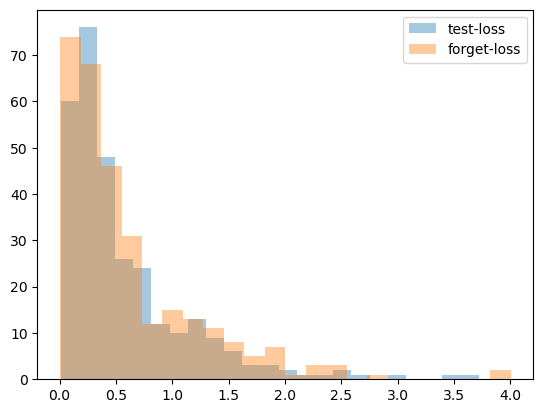

FPR:0.44, FNR:0.48, FP8.00, TN10.00, TP22.00, FN20.00
FPR:0.48, FNR:0.49, FP10.00, TN11.00, TP20.00, FN19.00
FPR:0.44, FNR:0.48, FP7.00, TN9.00, TP23.00, FN21.00
FPR:0.67, FNR:0.59, FP14.00, TN7.00, TP16.00, FN23.00
FPR:0.53, FNR:0.51, FP10.00, TN9.00, TP20.00, FN21.00
Attack accuracy for Original Model: 0.49000000000000005

Evaluating MIA on Negative Gradients Model...


C:\Users\shr91\AppData\Local\Temp\ipykernel_18472\485575046.py:103: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_losses, kde=False, label='test-loss')
C:\Users\shr91\AppData\Local\Temp\ipykernel_18472\485575046.py:104: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(forget_losses, kde=False,

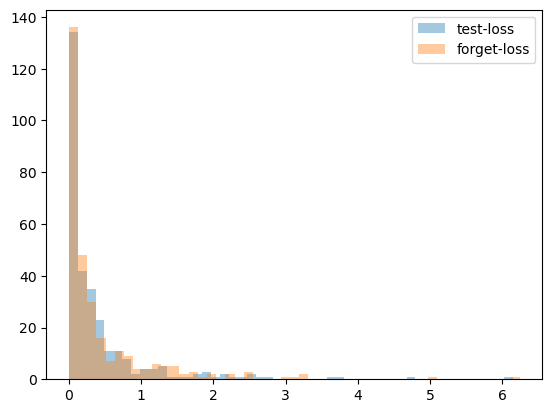

FPR:0.44, FNR:0.48, FP8.00, TN10.00, TP22.00, FN20.00
FPR:0.53, FNR:0.55, FP21.00, TN19.00, TP9.00, FN11.00
FPR:0.58, FNR:0.56, FP14.00, TN10.00, TP16.00, FN20.00
FPR:0.29, FNR:0.43, FP4.00, TN10.00, TP26.00, FN20.00
FPR:0.38, FNR:0.45, FP6.00, TN10.00, TP24.00, FN20.00
Attack accuracy for Negative Gradients Model: 0.5199999999999999

Evaluating MIA on Fisher Model...


C:\Users\shr91\AppData\Local\Temp\ipykernel_18472\485575046.py:103: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_losses, kde=False, label='test-loss')
C:\Users\shr91\AppData\Local\Temp\ipykernel_18472\485575046.py:104: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(forget_losses, kde=False,

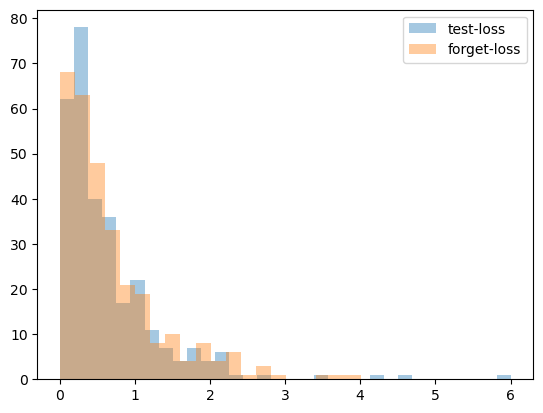

FPR:0.45, FNR:0.47, FP10.00, TN12.00, TP20.00, FN18.00
FPR:0.41, FNR:0.45, FP9.00, TN13.00, TP21.00, FN17.00
FPR:0.50, FNR:0.50, FP12.00, TN12.00, TP18.00, FN18.00
FPR:0.43, FNR:0.46, FP10.00, TN13.00, TP20.00, FN17.00
FPR:0.38, FNR:0.44, FP8.00, TN13.00, TP22.00, FN17.00
Attack accuracy for Fisher Model: 0.5466666666666667



In [40]:
import numpy as np
import torch.nn.functional as F
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import random
import matplotlib.pyplot as plt
import seaborn as sns

def cm_score(estimator, X, y):
    y_pred = estimator.predict(X)
    cnf_matrix = confusion_matrix(y, y_pred)
    
    FP = cnf_matrix[0][1] 
    FN = cnf_matrix[1][0] 
    TP = cnf_matrix[0][0] 
    TN = cnf_matrix[1][1]


    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print (f"FPR:{FPR:.2f}, FNR:{FNR:.2f}, FP{FP:.2f}, TN{TN:.2f}, TP{TP:.2f}, FN{FN:.2f}")
    return ACC


def evaluate_attack_model(sample_loss,
                          members,
                          n_splits = 5,
                          random_state = None):
  """Computes the cross-validation score of a membership inference attack.
  Args:
    sample_loss : array_like of shape (n,).
      objective function evaluated on n samples.
    members : array_like of shape (n,),
      whether a sample was used for training.
    n_splits: int
      number of splits to use in the cross-validation.
    random_state: int, RandomState instance or None, default=None
      random state to use in cross-validation splitting.
  Returns:
    score : array_like of size (n_splits,)
  """

  unique_members = np.unique(members)
  if not np.all(unique_members == np.array([0, 1])):
    raise ValueError("members should only have 0 and 1s")

  attack_model = LogisticRegression()
  cv = StratifiedShuffleSplit(
      n_splits=n_splits, random_state=random_state)
  return cross_val_score(attack_model, sample_loss, members, cv=cv, scoring=cm_score)

def membership_inference_attack(model, t_loader, f_loader, seed):
    cr = torch.nn.CrossEntropyLoss(reduction='none')
    test_losses = []
    forget_losses = []
    model.eval()

    mult = 0.5 if args.lossfn == 'mse' else 1

    # 获取测试集的losses
    for data, target in t_loader:
        data, target = data.to(args.device), target.to(args.device)
        if args.lossfn == 'mse':
            target = (2 * target - 1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        output = model(data)
        loss = mult * cr(output, target)
        test_losses.extend(loss.cpu().detach().numpy())

    # 获取forget set的losses
    for data, target in f_loader:
        data, target = data.to(args.device), target.to(args.device)
        if args.lossfn == 'mse':
            target = (2 * target - 1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        output = model(data)
        loss = mult * cr(output, target)
        forget_losses.extend(loss.cpu().detach().numpy())

    # 为了确保两者大小相同，进行采样
    min_len = min(len(test_losses), len(forget_losses))
    test_losses = np.random.choice(test_losses, min_len, replace=False)
    forget_losses = np.random.choice(forget_losses, min_len, replace=False)

    # 可视化
    sns.distplot(test_losses, kde=False, label='test-loss')
    sns.distplot(forget_losses, kde=False, label='forget-loss')
    plt.legend()
    plt.show()

    # 准备数据
    all_losses = np.concatenate((test_losses, forget_losses)).reshape(-1, 1)
    labels = np.array([0] * len(test_losses) + [1] * len(forget_losses))

    # 评估
    score = evaluate_attack_model(all_losses, labels, n_splits=5, random_state=seed)
    return score

# 进行模型的MIA评估
for model_name, model_instance in zip(
    ["Original Model", "Negative Gradients Model", "Fisher Model"],
    [model_original, model_negative_gradient, model_fisher]
):
    print(f"Evaluating MIA on {model_name}...")
    score = membership_inference_attack(model_instance, retain_loader, forget_loader, seed=42)
    print(f"Attack accuracy for {model_name}: {np.mean(score)}\n")

## CF-K

In [41]:
def CF_K(model: nn.Module, data_loader: torch.utils.data.DataLoader, args, lr=0.01, epochs=10):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        sgda_adjust_learning_rate(epoch, args, optimizer)
        run_CF_K_epoch(model, model_init, data_loader, loss_fn, optimizer, epoch=epoch)

In [42]:
def run_CF_K_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, epoch: int):
    model.eval()
    metrics = AverageMeter()
    with torch.set_grad_enabled(True):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            model.zero_grad()
            loss.backward()
            optimizer.step()
    return metrics.avg

In [43]:
args.lr_decay_epochs = [10,15,20]
args.cfk_lr = 0.01
args.cfk_epochs = 10
model_cfk = copy.deepcopy(model)

for param in model_cfk.parameters():
    param.requires_grad_(False)

if args.model == 'allcnn':
    layers = [9]
    for k in layers:
        for param in model_cfk.features[k].parameters():
            param.requires_grad_(True)
elif args.model == "resnet":
    for param in model_cfk.layer4.parameters():
        param.requires_grad_(True)
else:
    print("CF-K is not applicable")
    raise NotImplementedError

CF_K(model_cfk, retain_loader, args=args, epochs=args.cfk_epochs, lr=args.cfk_lr)

CF-K is not applicable


NotImplementedError: 

## EU-K

In [ ]:
def run_eu_k_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = AverageMeter()
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))

            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [ ]:
def EU_K(model: nn.Module, data_loader: torch.utils.data.DataLoader, args, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        sgda_adjust_learning_rate(epoch, args, optimizer)
        run_eu_k_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)

In [ ]:
args.lr_decay_epochs = [10,15,20]
args.euk_lr = 0.01
args.euk_epochs = training_epochs
model_euk = copy.deepcopy(model)

for param in model_euk.parameters():
    param.requires_grad_(False)

if args.model == 'allcnn':
    with torch.no_grad():
        for k in layers:
            for i in range(0,3):
                try:
                    model_euk.features[k][i].weight.copy_(model_initial.features[k][i].weight)
                except:
                    print ("block {}, layer {} does not have weights".format(k,i))
                try:
                    model_euk.features[k][i].bias.copy_(model_initial.features[k][i].bias)
                except:
                    print ("block {}, layer {} does not have bias".format(k,i))
        model_euk.classifier[0].weight.copy_(model_initial.classifier[0].weight)
        model_euk.classifier[0].bias.copy_(model_initial.classifier[0].bias)

    for k in layers:
        for param in model_euk.features[k].parameters():
            param.requires_grad_(True)

elif args.model == "resnet":
    with torch.no_grad():
        for i in range(0,2):
            try:
                model_euk.layer4[i].bn1.weight.copy_(model_initial.layer4[i].bn1.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].bn1.bias.copy_(model_initial.layer4[i].bn1.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))
            try:
                model_euk.layer4[i].conv1.weight.copy_(model_initial.layer4[i].conv1.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].conv1.bias.copy_(model_initial.layer4[i].conv1.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))

            try:
                model_euk.layer4[i].bn2.weight.copy_(model_initial.layer4[i].bn2.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].bn2.bias.copy_(model_initial.layer4[i].bn2.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))
            try:
                model_euk.layer4[i].conv2.weight.copy_(model_initial.layer4[i].conv2.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].conv2.bias.copy_(model_initial.layer4[i].conv2.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))

        model_euk.layer4[0].shortcut[0].weight.copy_(model_initial.layer4[0].shortcut[0].weight)

    for param in model_euk.layer4.parameters():
        param.requires_grad_(True)

else:
    print("EU_K is not applicable")
    raise NotImplementedError

EU_K is not applicable


NotImplementedError: 

In [ ]:
EU_K(model_euk, retain_loader, epochs=args.euk_epochs, quiet=True, lr=args.euk_lr, args=args)

  0%|          | 0/373 [00:00<?, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## SCRUB

In [ ]:
args.optim = 'adam'
args.gamma = 1
args.alpha = 0.5
args.beta = 0
args.smoothing = 0.5
args.msteps = 3
args.clip = 0.2
args.sstart = 10
args.kd_T = 2
args.distill = 'kd'

args.sgda_epochs = 10
args.sgda_learning_rate = 0.0005
args.lr_decay_epochs = [5,8,9]
args.lr_decay_rate = 0.1
args.sgda_weight_decay = 0.1#5e-4
args.sgda_momentum = 0.9

In [ ]:
teacher = copy.deepcopy(model)
student = copy.deepcopy(model)

In [ ]:
model_t = copy.deepcopy(teacher)
model_s = copy.deepcopy(student)

In [ ]:
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s, avg_fn=avg_fn)

In [ ]:
module_list = nn.ModuleList([])
module_list.append(model_s)
trainable_list = nn.ModuleList([])
trainable_list.append(model_s)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(args.kd_T)
criterion_kd = DistillKL(args.kd_T)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

# optimizer
if args.optim == "sgd":
    optimizer = optim.SGD(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "adam":
    optimizer = optim.Adam(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "rmsp":
    optimizer = optim.RMSprop(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)

In [ ]:
module_list.append(model_t)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True
    swa_model.cuda()

In [ ]:
acc_rs = []
acc_fs = []
acc_ts = []
for epoch in range(1, args.sgda_epochs + 1):

    lr = sgda_adjust_learning_rate(epoch, args, optimizer)

    print("==> scrub unlearning ...")

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())

    maximize_loss = 0
    if epoch <= args.msteps:
        maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    train_acc, train_loss = train_distill(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer, args, "minimize",)
    if epoch >= args.sstart:
        swa_model.update_parameters(model_s)

    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))


==> scrub unlearning ...


/Users/billdeng/anaconda3/envs/unlearning_Version1/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.728 
maximize loss: 0.07	 minimize loss: 1.88	 train_acc: 87.7284927368164
==> scrub unlearning ...
 * Acc@1 87.787 
maximize loss: 1.48	 minimize loss: 2.11	 train_acc: 87.78718566894531
==> scrub unlearning ...
 * Acc@1 87.823 
maximize loss: 1.49	 minimize loss: 2.11	 train_acc: 87.82282257080078
==> scrub unlearning ...
 * Acc@1 87.812 
maximize loss: 0.00	 minimize loss: 2.11	 train_acc: 87.81233978271484
==> scrub unlearning ...
 * Acc@1 87.743 
maximize loss: 0.00	 minimize loss: 2.11	 train_acc: 87.7431640625
==> scrub unlearning ...
 * Acc@1 87.879 
maximize loss: 0.00	 minimize loss: 2.10	 train_acc: 87.87942504882812
==> scrub unlearning ...
 * Acc@1 87.926 
maximize loss: 0.00	 minimize loss: 2.09	 train_acc: 87.925537109375
==> scrub unlearning ...
 * Acc@1 87.938 
maximize loss: 0.00	 minimize loss: 2.09	 train_acc: 87.93811798095703
==> scrub unlearning ...
 * Acc@1 87.959 
maximize loss: 0.00	 minimize loss: 2.09	 train_acc: 87.9590835571289
==> scrub unlear

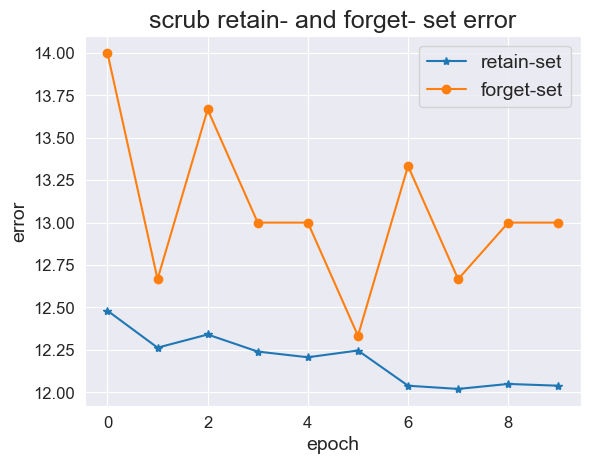

In [ ]:
from matplotlib import pyplot as plt
indices = list(range(0,len(acc_rs)))
plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
plt.legend(prop={'size': 14})
plt.tick_params(labelsize=12)
plt.title('scrub retain- and forget- set error',size=18)
plt.xlabel('epoch',size=14)
plt.ylabel('error',size=14)
plt.show()

## NTK